In [1]:
install.packages("leaps")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
library(tidyverse)
library(leaps)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [14]:
df0 = read.table("./data/data.csv", sep = ",", header=TRUE)

In [16]:
# drop variables we don't use
df = df0 |> select(-Release.Date..US., -Oscar.Detail, -X..of.Gross.earned.abroad)
colnames(df) = c("film", "year", "rt_cr", "meta_cr", "rt_au", "meta_au", "pr_genre", "op_weekend", "domestic_gross", "foreign_gross", "world_gross", "budget", "oscar", "distr", "imdb")
df = df |> select(-film, -foreign_gross, -world_gross)
df <- na.omit(df)

In [17]:
df |> group_by(distr) |>
summarize(mean = mean(domestic_gross)) |>
arrange(desc(mean))

table(df$distr)

#Based on this, we choose these as the primary distributors and let the others be "Other"
#c("Walt Disney Studios Motion Pictures", "Paramount Pictures", "Warner Bros. Pictures", "Universal Pictures", "Sony Pictures")

distr,mean
<chr>,<dbl>
Walt Disney Studios Motion Pictures,205.94286
Paramount Pictures,108.97692
Warner Bros. Pictures,105.67273
Universal Pictures,65.75484
Sony Pictures,62.82857
Metro-Goldwyn-Mayer (MGM),34.80000
A24,32.80000
20th Century Studios,31.95714
STX Entertainment,24.55000



                        101 Studios                20th Century Studios 
                                  1                                   7 
                                A24                   Bloody Disgusting 
                                  3                                   1 
                     Focus Features                   Gravitas Ventures 
                                  7                                   2 
                          IFC Films                        IFC Midnight 
                                  1                                   1 
                   LD Entertainment                           Lionsgate 
                                  1                                   2 
                    Lionsgate Films           Metro-Goldwyn-Mayer (MGM) 
                                  4                                   2 
                    Open Road Films                      Orion Pictures 
                                  1               

In [18]:
df$oscar <- ifelse(df$oscar == "", "Not Oscar Winner", df$oscar)
df$distr <- ifelse(df$distr %in% c("Walt Disney Studios Motion Pictures", "Paramount Pictures", "Warner Bros. Pictures", "Universal Pictures", "Sony Pictures"), df$distr, "Other")

In [19]:
df$year <- as.factor(df$year)
df$oscar <- as.factor(df$oscar)
df$pr_genre <- as.factor(df$pr_genre)
df$distr <- as.factor(df$distr)

In [20]:
head(df)

,year,rt_cr,meta_cr,rt_au,meta_au,pr_genre,op_weekend,domestic_gross,budget,oscar,distr,imdb
,<fct>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,2022,69,55,88,56,thriller,8.7,22.3,40.0,Not Oscar Winner,Universal Pictures,6.1
2,2022,32,48,62,52,comedy,6.4,14.9,80.0,Not Oscar Winner,Walt Disney Studios Motion Pictures,6.1
3,2022,75,74,48,66,drama,0.1,1.9,15.0,Not Oscar Winner,Universal Pictures,6.5
4,2022,57,61,52,70,comedy,3.6,15.4,110.0,Not Oscar Winner,Paramount Pictures,7.1
5,2022,92,78,71,74,thriller,10.5,40.8,4.5,Not Oscar Winner,Other,7.0
6,2022,68,54,77,48,thriller,11.6,31.8,36.0,Not Oscar Winner,Universal Pictures,5.6


In [28]:
s = regsubsets(I(log(domestic_gross) ~ year + pr_genre + rt_cr + meta_cr + rt_au + meta_au + budget + oscar + imdb + distr), data = df, method = "exhaustive")

In [29]:
ss = summary(s)
ss

Subset selection object
Call: regsubsets.formula(I(log(domestic_gross) ~ year + pr_genre + 
    rt_cr + meta_cr + rt_au + meta_au + budget + oscar + imdb + 
    distr), data = df, method = "exhaustive")
23 Variables  (and intercept)
                                         Forced in Forced out
year2022                                     FALSE      FALSE
pr_genreadventure                            FALSE      FALSE
pr_genreanimation                            FALSE      FALSE
pr_genrebiography                            FALSE      FALSE
pr_genrecomedy                               FALSE      FALSE
pr_genrecrime                                FALSE      FALSE
pr_genredrama                                FALSE      FALSE
pr_genrefantasy                              FALSE      FALSE
pr_genrehorror                               FALSE      FALSE
pr_genreromance                              FALSE      FALSE
pr_genrethriller                             FALSE      FALSE
rt_cr                  

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


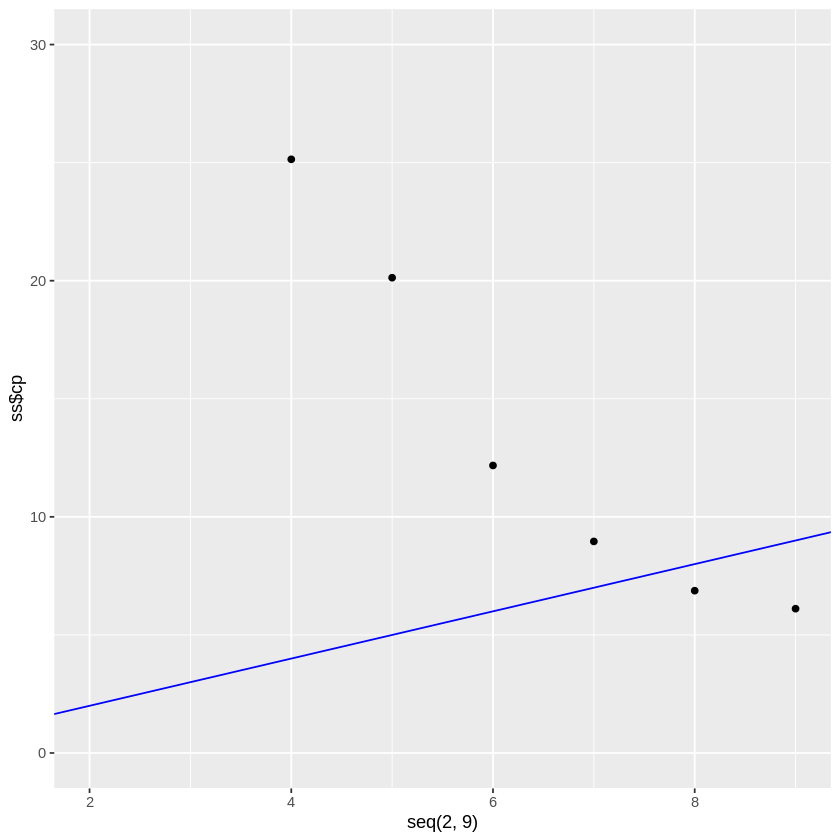

In [30]:
ggplot() +
  geom_point(aes(x = seq(2, 9), y = ss$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 30)

In [62]:
ss$bic

[1] -49.89924 -56.82583 -64.66911 -66.17909 -70.93229 -71.46102 -71.00502
[8] -69.23505

In [63]:
# corresponding row 7 of the regsubset table

m1 = lm(I(log(domestic_gross) ~ year + pr_genre + meta_cr + budget + imdb + distr), data = df)

In [27]:
summary(m1)


Call:
lm(formula = I(log(domestic_gross) ~ year + pr_genre + meta_cr + 
    budget + imdb + distr), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.79802 -0.55941  0.08683  0.61362  1.78177 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -1.968425   0.802218  -2.454  0.01585
year2022                                  0.396507   0.210705   1.882  0.06274
pr_genreadventure                         0.148223   0.362562   0.409  0.68354
pr_genreanimation                         0.125491   1.063622   0.118  0.90631
pr_genrebiography                        -1.155404   1.065224  -1.085  0.28066
pr_genrecomedy                            0.148637   0.387991   0.383  0.70246
pr_genrecrime                            -0.555568   0.558330  -0.995  0.32209
pr_genredrama                            -0.243424   0.355779  -0.684  0.49542
pr_genrefantasy                          -0.229038   1.079

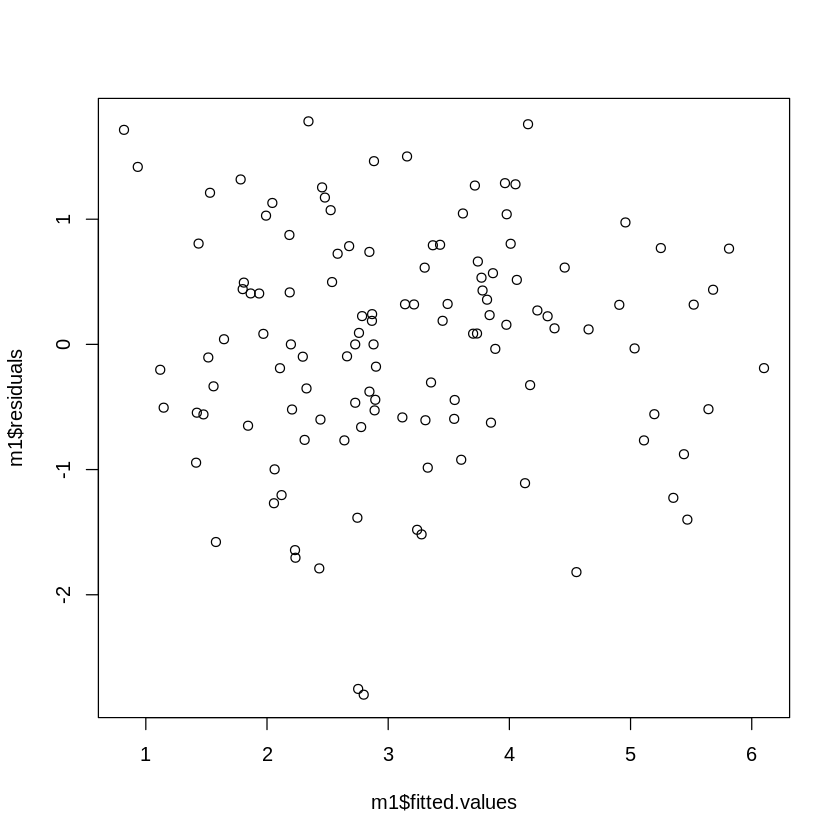

In [37]:
plot(m1$fitted.values, m1$residuals)

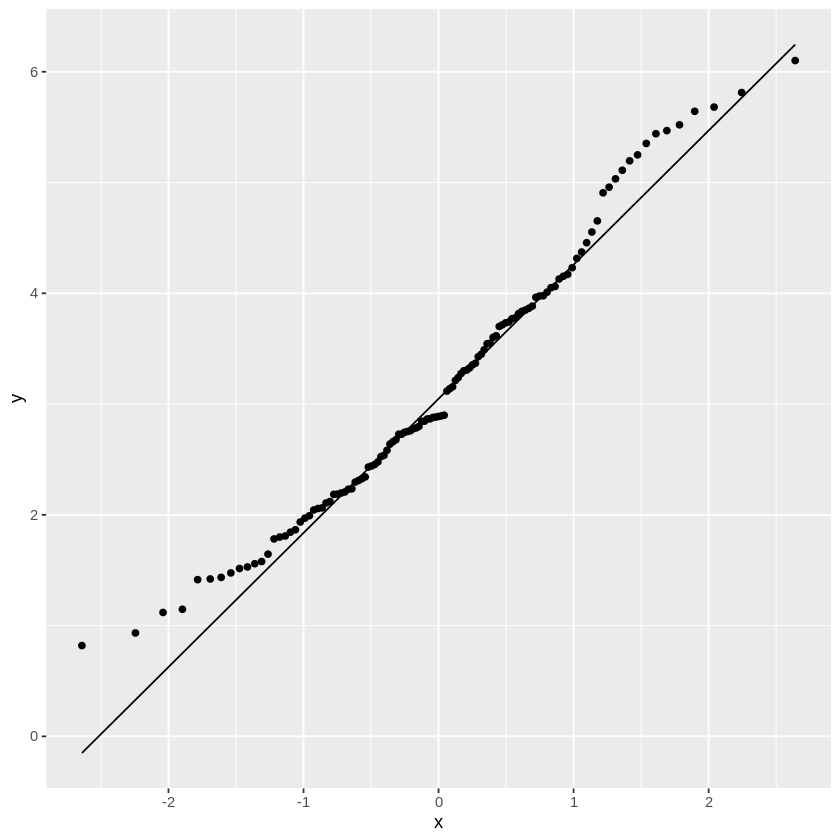

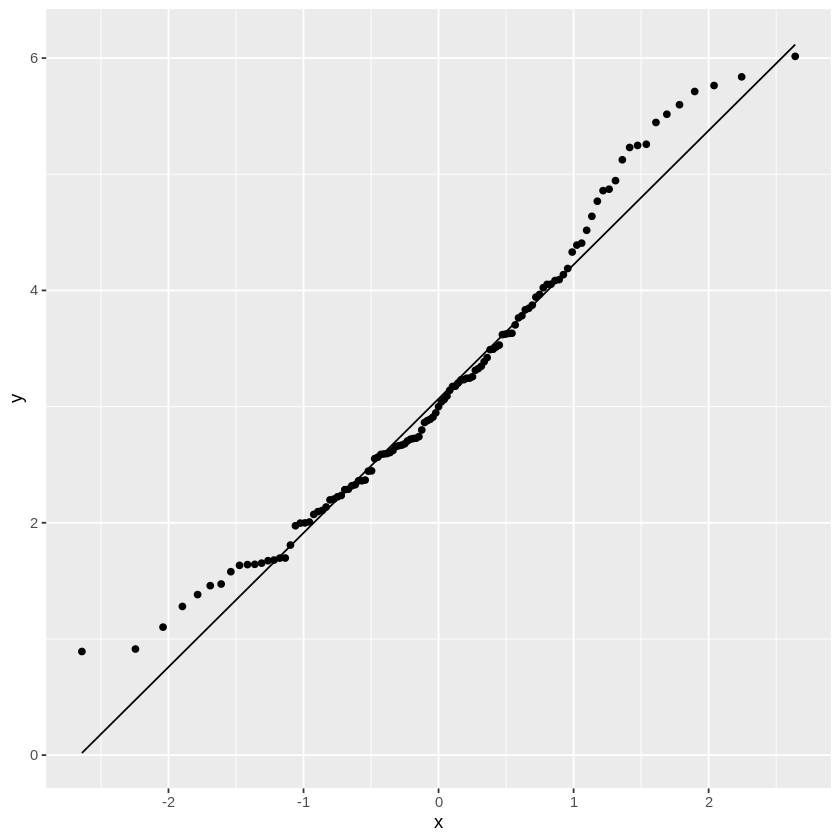

In [68]:
ggplot() + stat_qq(aes(sample = m1$fitted.values)) + stat_qq_line(aes(sample =  m1$fitted.values))
ggplot() + stat_qq(aes(sample = m2$fitted.values)) + stat_qq_line(aes(sample =  m2$fitted.values))

Maybe exclude some outliers?


Call:
lm(formula = I(log(domestic_gross) ~ pr_genre + meta_cr + budget + 
    imdb + distr), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.94610 -0.48586  0.07976  0.68298  1.97046 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -2.021361   0.811650  -2.490 0.014373
pr_genreadventure                        -0.012474   0.356725  -0.035 0.972173
pr_genreanimation                         0.278058   1.073657   0.259 0.796171
pr_genrebiography                        -1.163071   1.078404  -1.079 0.283349
pr_genrecomedy                            0.175010   0.392538   0.446 0.656657
pr_genrecrime                            -0.591308   0.564915  -1.047 0.297703
pr_genredrama                            -0.282847   0.359559  -0.787 0.433310
pr_genrefantasy                          -0.498103   1.083531  -0.460 0.646707
pr_genrehorror                            1.163120   0.445319   2

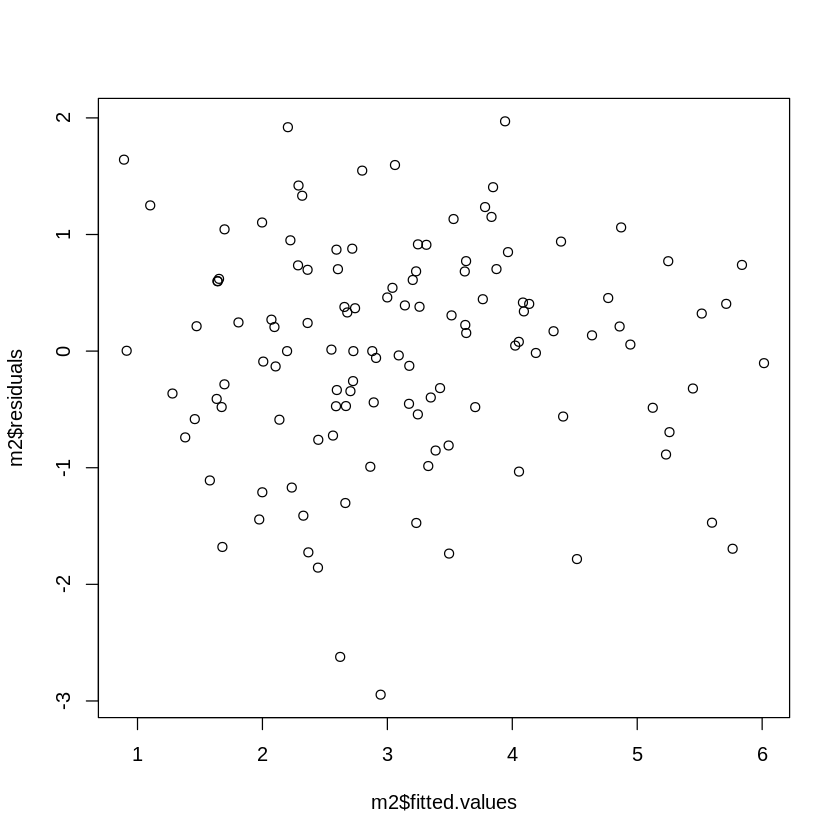

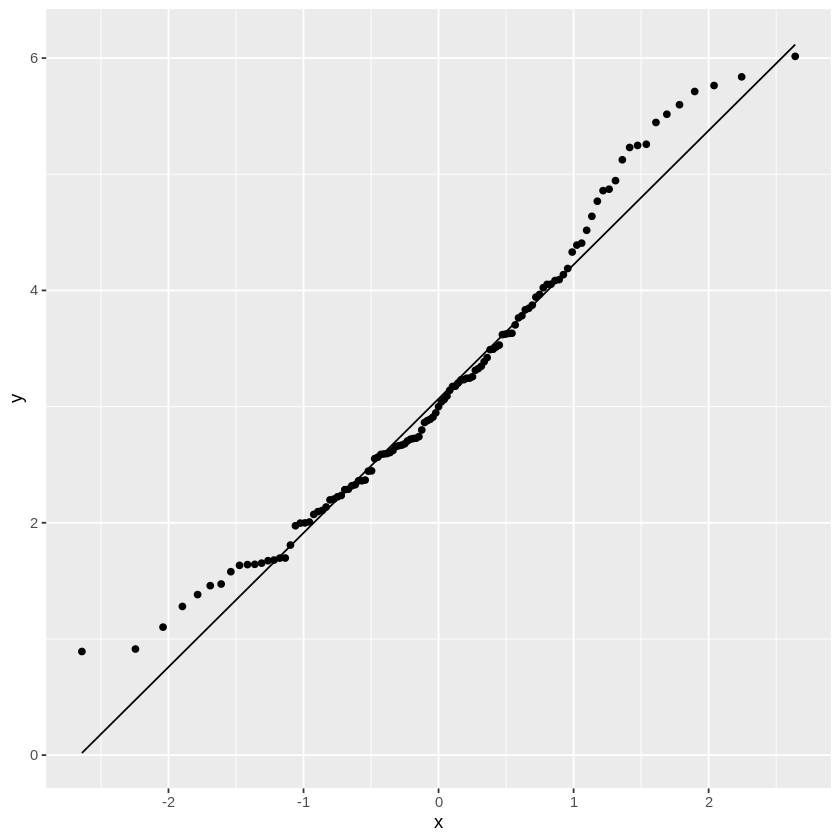

In [64]:
m2 = lm(I(log(domestic_gross) ~ pr_genre + meta_cr + budget + imdb + distr), data = df)

summary(m2)
plot(m2$fitted.values, m2$residuals)
ggplot() + stat_qq(aes(sample = m2$fitted.values)) + stat_qq_line(aes(sample =  m2$fitted.values))

In [66]:
AIC(m1)
AIC(m2)

BIC(m1)
BIC(m2)

[1] 363.0499

[1] 365.2197

[1] 421.7615

[1] 421.1355


Call:
lm(formula = I(log(domestic_gross) ~ pr_genre + budget + distr + 
    imdb), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.00063 -0.63483  0.08356  0.66167  1.95847 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -1.588322   0.785908  -2.021 0.045874
pr_genreadventure                         0.075102   0.357640   0.210 0.834088
pr_genreanimation                         0.339753   1.085558   0.313 0.754932
pr_genrebiography                        -1.307002   1.088025  -1.201 0.232405
pr_genrecomedy                            0.187421   0.397024   0.472 0.637878
pr_genrecrime                            -0.514303   0.569890  -0.902 0.368919
pr_genredrama                            -0.271676   0.363669  -0.747 0.456741
pr_genrefantasy                          -0.885385   1.075275  -0.823 0.412181
pr_genrehorror                            1.060766   0.446959   2.373 0.019

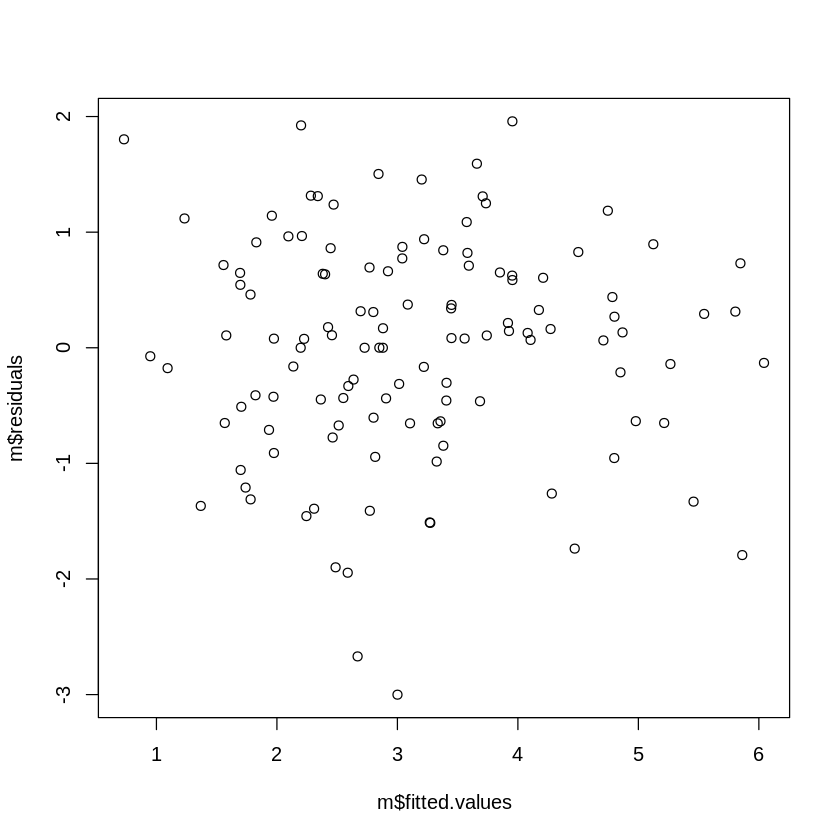

In [87]:
m3 = lm(I(log(domestic_gross) ~ pr_genre +  budget + distr + imdb), data = df)
viz(m3)






Call:
lm(formula = I(sqrt(domestic_gross) ~ pr_genre + meta_cr + poly(budget, 
    2) + imdb + distr), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-7.356 -1.538  0.000  1.547 10.750 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -6.67264    2.53581  -2.631  0.00984
pr_genreadventure                        -1.09325    1.11754  -0.978  0.33028
pr_genreanimation                        -2.36885    3.33842  -0.710  0.47960
pr_genrebiography                        -5.03111    3.35347  -1.500  0.13666
pr_genrecomedy                           -1.36892    1.22260  -1.120  0.26551
pr_genrecrime                            -2.83384    1.78938  -1.584  0.11639
pr_genredrama                            -1.64852    1.12203  -1.469  0.14488
pr_genrefantasy                          -4.04237    3.38402  -1.195  0.23506
pr_genrehorror                            1.80010    1.42747   1.261  0.21020
pr_gen

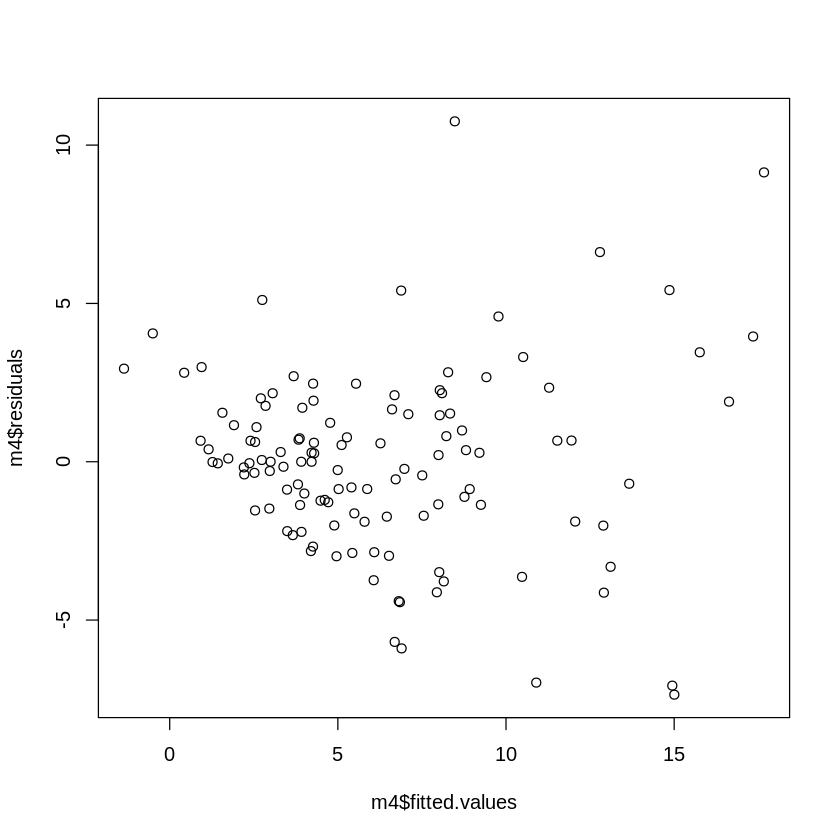

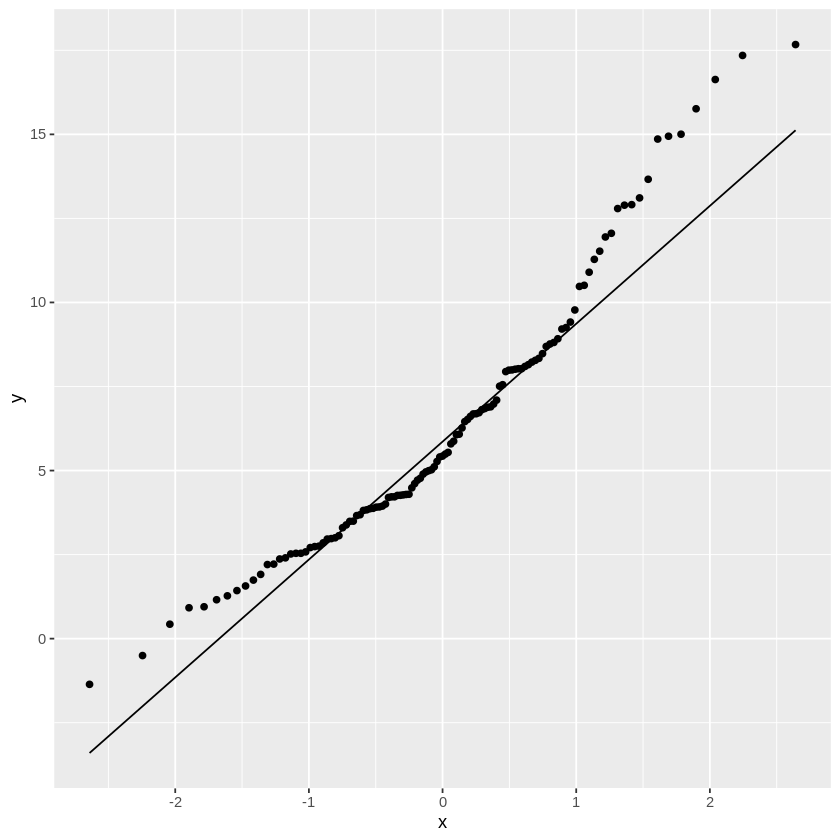

In [42]:
m4 = lm(I(sqrt(domestic_gross) ~ pr_genre + meta_cr + poly(budget, 2) + imdb + distr), data = df)

summary(m4)
plot(m4$fitted.values, m4$residuals)
ggplot() + stat_qq(aes(sample = m4$fitted.values)) + stat_qq_line(aes(sample =  m4$fitted.values))


Call:
lm(formula = I(log(domestic_gross) ~ year + pr_genre + budget + 
    distr + imdb), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8834 -0.5819  0.0417  0.7109  1.8830 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -1.490601   0.782919  -1.904 0.059741
year2022                                  0.331989   0.212028   1.566 0.120498
pr_genreadventure                         0.220449   0.367077   0.601 0.549470
pr_genreanimation                         0.219618   1.080715   0.203 0.839371
pr_genrebiography                        -1.318330   1.080462  -1.220 0.225220
pr_genrecomedy                            0.166870   0.394474   0.423 0.673171
pr_genrecrime                            -0.474882   0.566476  -0.838 0.403817
pr_genredrama                            -0.237289   0.361800  -0.656 0.513393
pr_genrefantasy                          -0.707857   1.073780  -0.659 0.511240

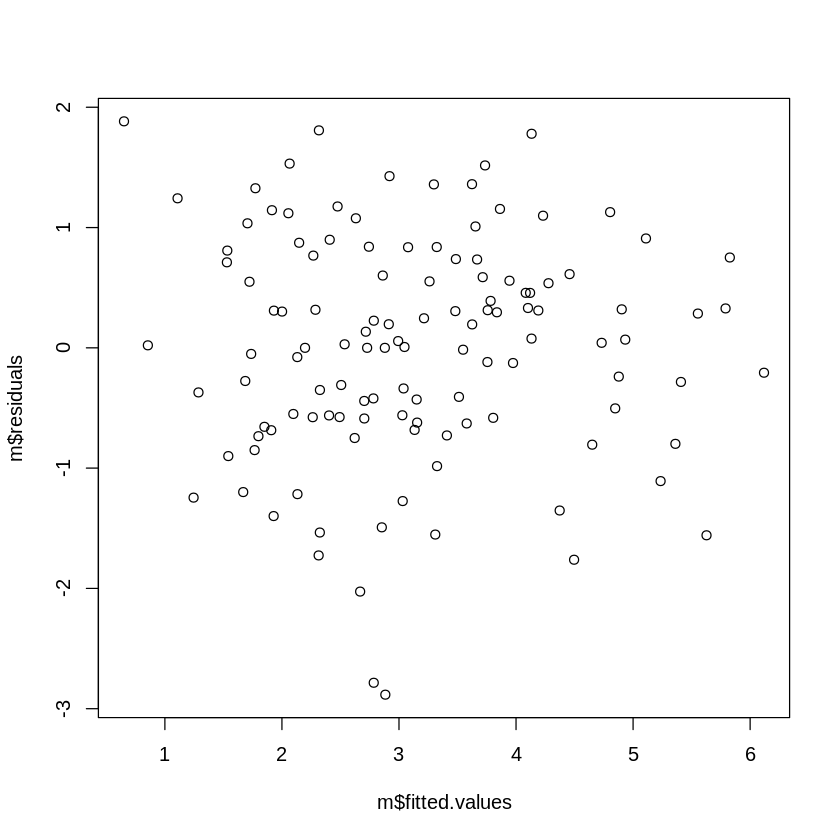

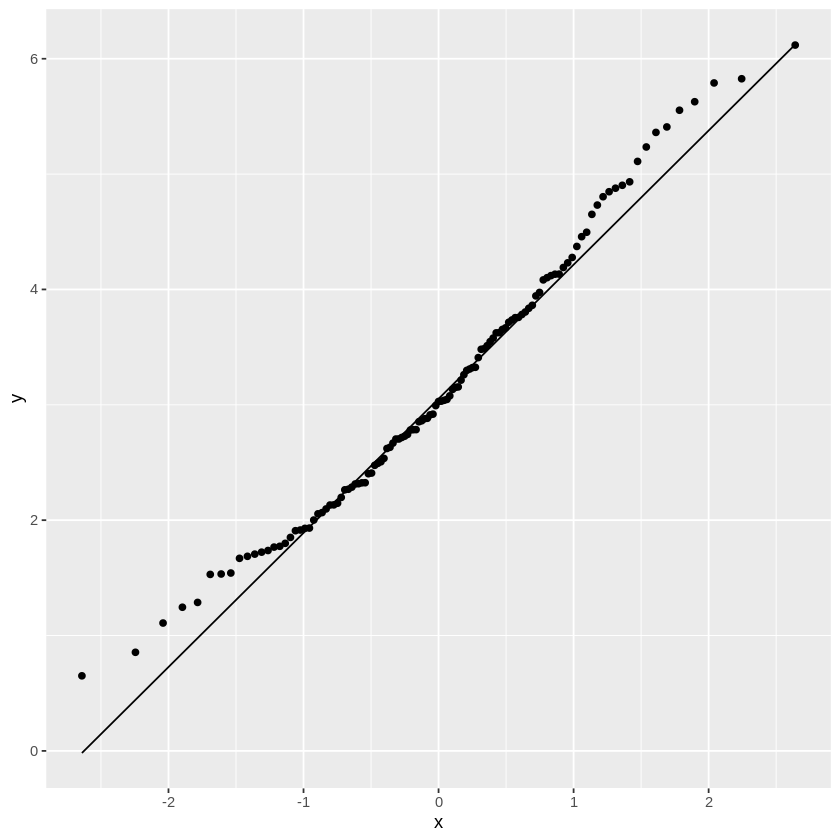

In [89]:
m4 = lm(I(log(domestic_gross) ~ year + pr_genre +  budget + distr + imdb), data = df)
viz(m4)
ggplot() + stat_qq(aes(sample = m4$fitted.values)) + stat_qq_line(aes(sample =  m4$fitted.values))

In [44]:
AIC(m1)
AIC(m2)
AIC(m3)
AIC(m4)
AIC(m5)


[1] 363.0499

[1] 637.3838

[1] 639.24

[1] 640.5536

[1] 640.1654

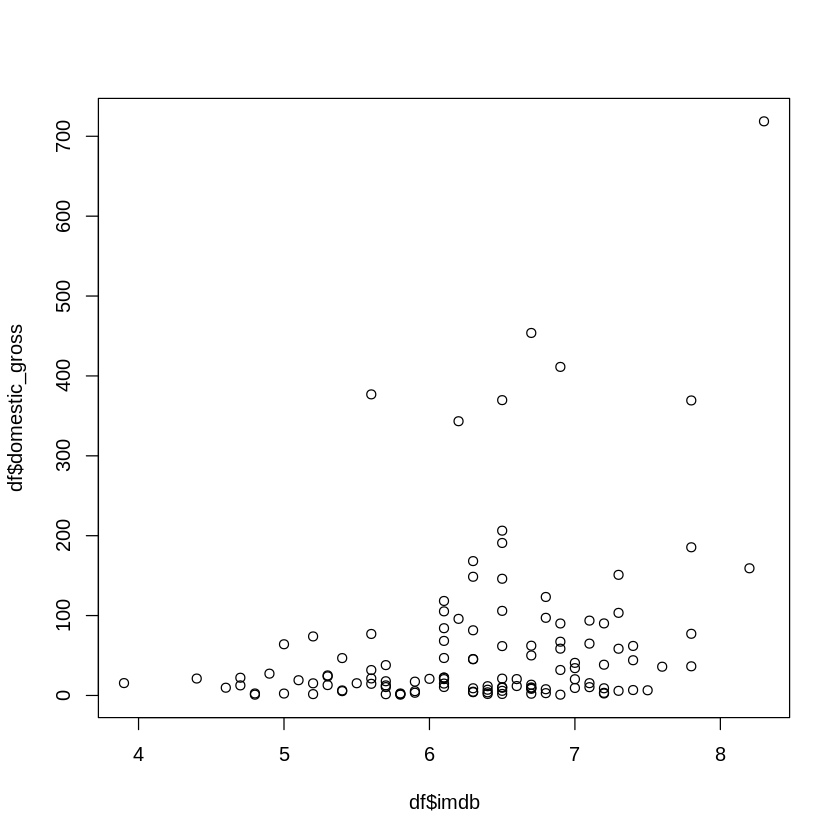

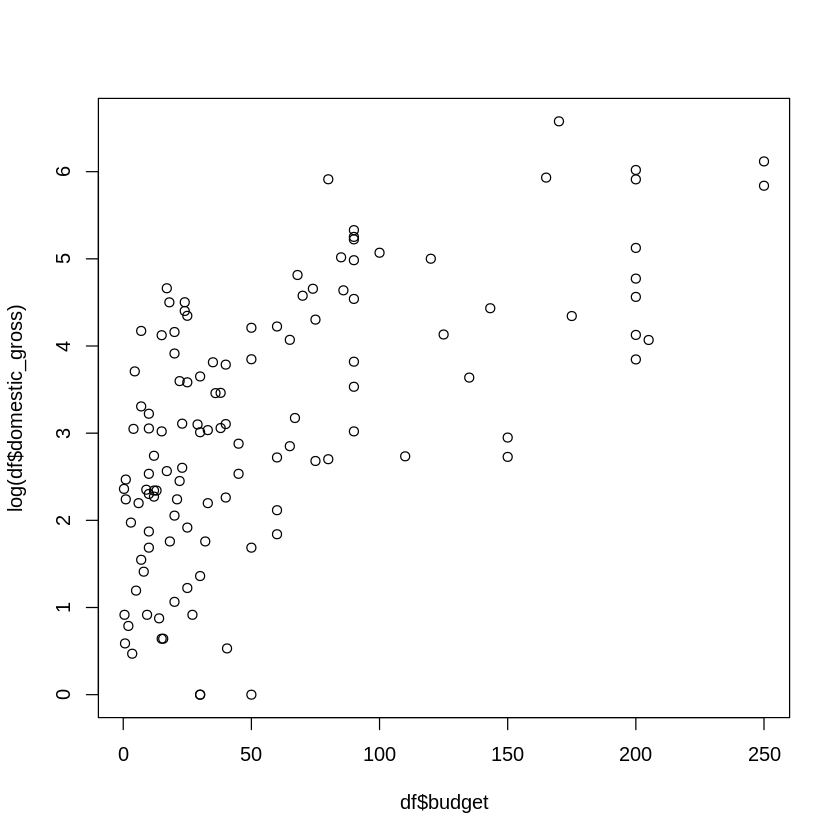

[1] 0.2923734

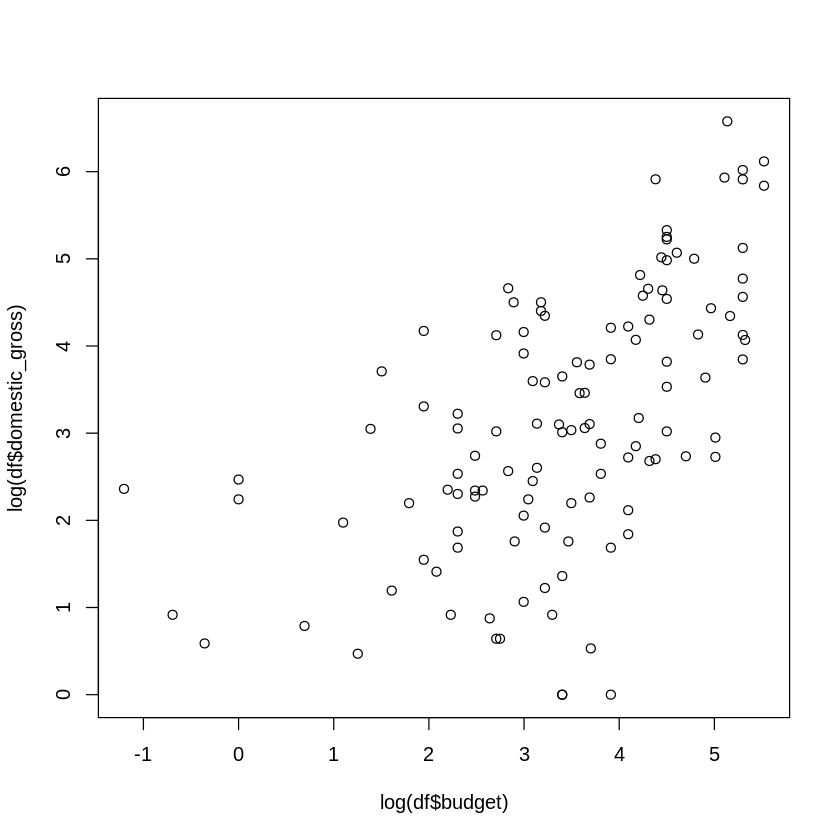

In [59]:
plot(y = df$domestic_gross, x = df$imdb)
plot(y = log(df$domestic_gross), x = df$budget)
plot(y = log(df$domestic_gross), x = log(df$budget))
cor(y = log(df$domestic_gross), x = df$imdb)


Call:
lm(formula = I(sqrt(domestic_gross) ~ pr_genre + budget + poly(budget, 
    2) + imdb + distr), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-7.566 -1.566  0.000  1.811 10.693 

Coefficients: (1 not defined because of singularities)
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -8.387906   2.445861  -3.429 0.000874
pr_genreadventure                        -0.871206   1.118294  -0.779 0.437755
pr_genreanimation                        -2.196482   3.363952  -0.653 0.515260
pr_genrebiography                        -5.419751   3.372292  -1.607 0.111115
pr_genrecomedy                           -1.325205   1.232273  -1.075 0.284726
pr_genrecrime                            -2.576143   1.796947  -1.434 0.154738
pr_genredrama                            -1.604945   1.130861  -1.419 0.158883
pr_genrefantasy                          -5.149045   3.342575  -1.540 0.126549
pr_genrehorror                     

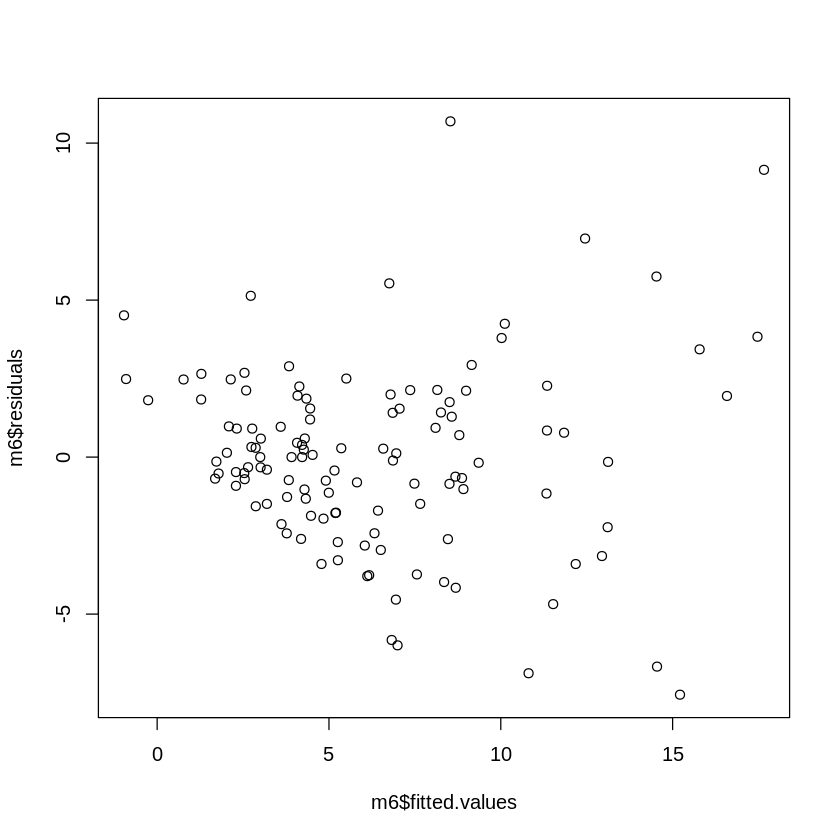

[1] 641.7106

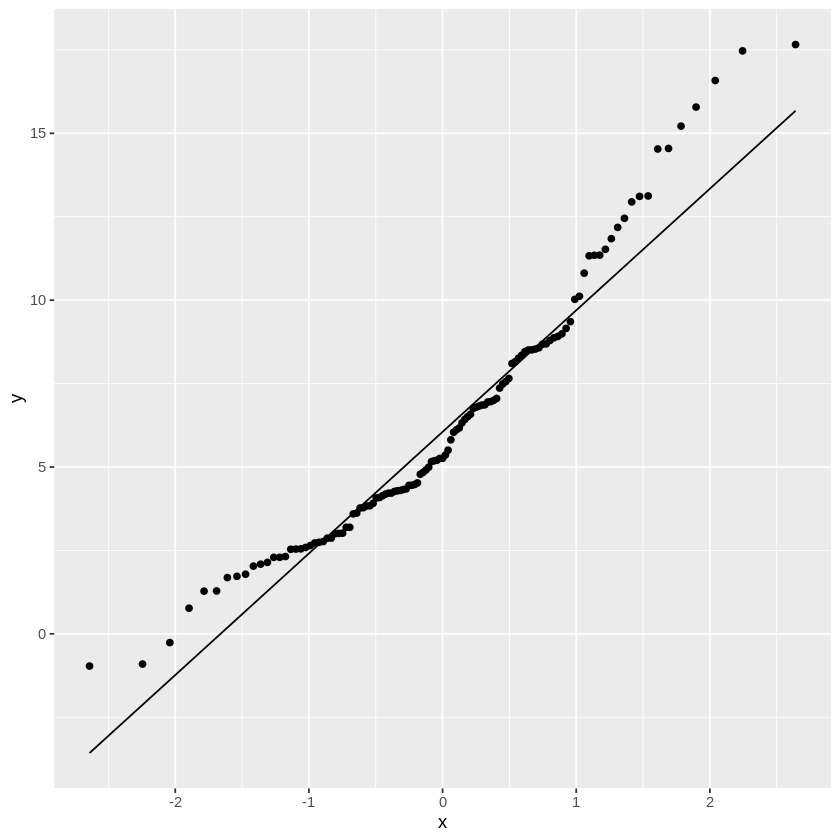

In [57]:
m6 = lm(I(sqrt(domestic_gross) ~ pr_genre + budget + poly(budget, 2) + imdb + distr), data = df)

summary(m6)
plot(m6$fitted.values, m6$residuals)
ggplot() + stat_qq(aes(sample = m6$fitted.values)) + stat_qq_line(aes(sample =  m6$fitted.values))
AIC(m6)

## WHich transformation??


Call:
lm(formula = I(sqrt(domestic_gross) ~ pr_genre + budget + imdb + 
    distr), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-7.280 -1.720  0.000  1.821 10.585 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -8.247666   2.428079  -3.397  0.00097
pr_genreadventure                        -0.963863   1.104937  -0.872  0.38506
pr_genreanimation                        -2.188406   3.353854  -0.653  0.51553
pr_genrebiography                        -5.376552   3.361476  -1.599  0.11278
pr_genrecomedy                           -1.281972   1.226614  -1.045  0.29841
pr_genrecrime                            -2.370267   1.760688  -1.346  0.18119
pr_genredrama                            -1.546614   1.123564  -1.377  0.17164
pr_genrefantasy                          -5.313215   3.322085  -1.599  0.11280
pr_genrehorror                            1.790977   1.380890   1.297  0.19754
pr_genreromance

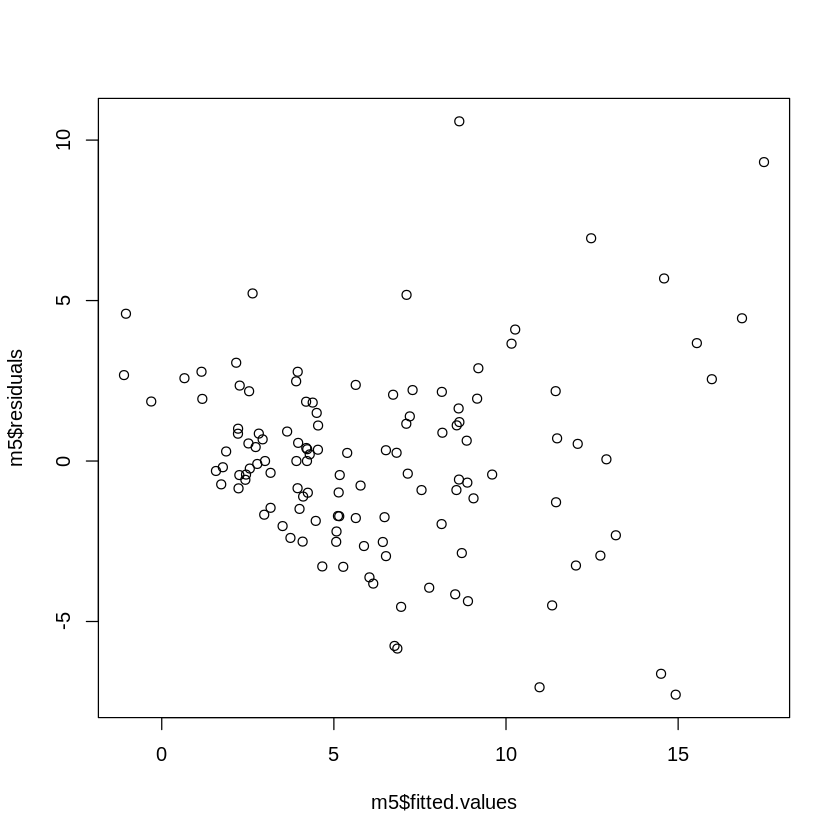

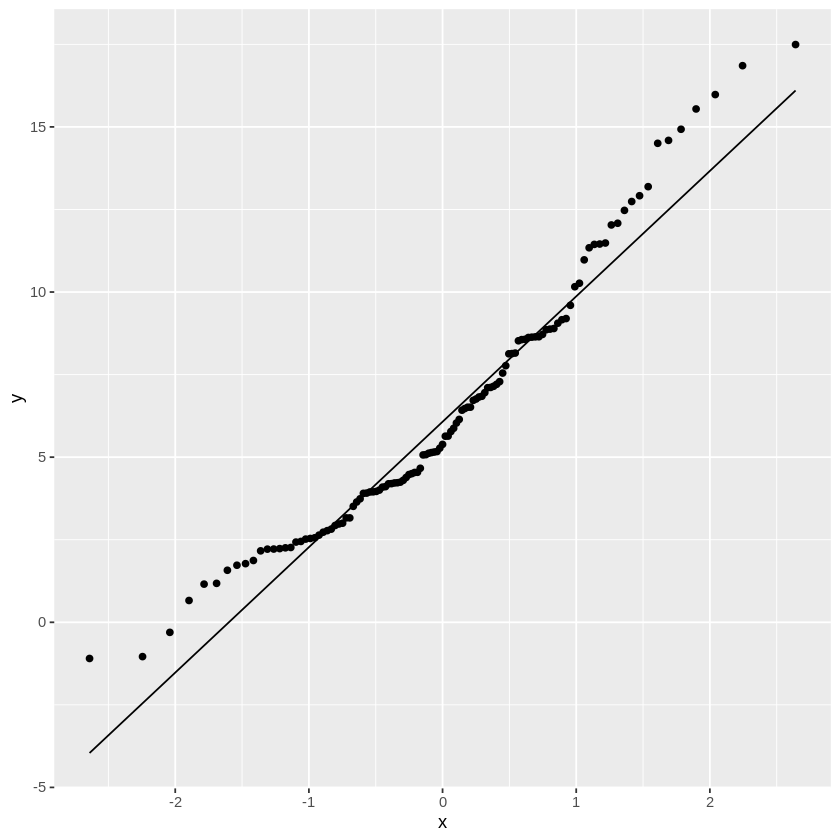

In [43]:
m5 = lm(I(sqrt(domestic_gross) ~ pr_genre + budget + imdb + distr), data = df)

summary(m5)
plot(m5$fitted.values, m5$residuals)
ggplot() + stat_qq(aes(sample = m5$fitted.values)) + stat_qq_line(aes(sample =  m5$fitted.values))



Call:
lm(formula = I(domestic_gross) ~ pr_genre + meta_cr + budget + 
    imdb + distr, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-170.46  -31.72   -2.60   20.85  401.77 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -229.1751    62.8407  -3.647  0.00042
pr_genreadventure                         -45.7566    27.6188  -1.657  0.10065
pr_genreanimation                         -74.9587    83.1261  -0.902  0.36932
pr_genrebiography                         -93.6945    83.4937  -1.122  0.26442
pr_genrecomedy                            -36.7615    30.3916  -1.210  0.22923
pr_genrecrime                             -48.1899    43.7376  -1.102  0.27314
pr_genredrama                             -28.6167    27.8382  -1.028  0.30640
pr_genrefantasy                          -112.1176    83.8906  -1.336  0.18437
pr_genrehorror                             18.3868    34.4781   0.533  0.59499
p

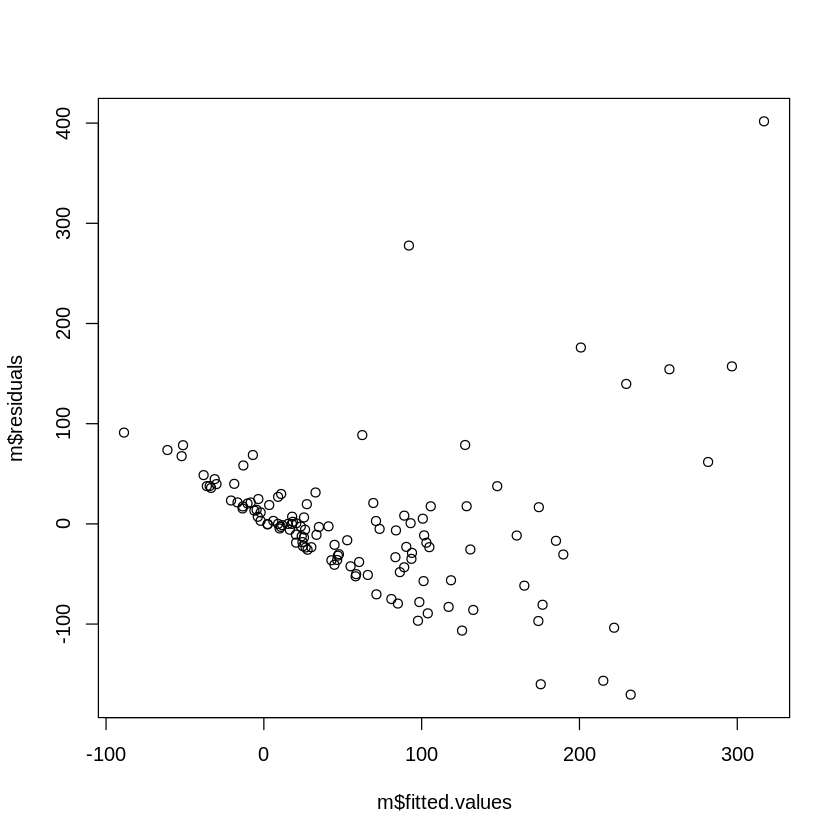

In [82]:
m10 = lm(I(domestic_gross) ~ pr_genre + meta_cr + budget + imdb + distr, data = df)

viz <- function (m) {
  # function body
    print(summary(m))
    plot(m$fitted.values, m$residuals)
    ggplot() + stat_qq(aes(sample = m$fitted.values)) + stat_qq_line(aes(sample =  m$fitted.values))
    print("AIC ")
    print(AIC(m))
    print("BIC ")
    print(BIC(m))
    
    
}


# summary(m10)
# plot(m10$fitted.values, m10$residuals)
# ggplot() + stat_qq(aes(sample = m10$fitted.values)) + stat_qq_line(aes(sample =  m10$fitted.values))


viz(m10)